In [12]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel
df_raw = pd.read_excel("GHG Emmission.xlsx", header=None)

# Extract column headers
years = []
for col in df_raw.iloc[0, 2:]:
    try:
        years.append(int(float(col)))
    except:
        years.append(None)

# Identify rows with "European Union - 27 countries" and a valid sector name
df_data = df_raw[1:].copy()  # skip header
df_data.columns = ["Location", "Sector"] + years
df_data = df_data[df_data["Location"].str.contains("European Union", na=False)]

# Specify the sector of interest
sector_name = "Total combustion"

# Extract the correct row
row = df_data[df_data["Sector"].str.strip() == sector_name]

if row.empty:
    print(" Sector not found or misnamed.")
else:
    raw_values = row.iloc[0, 2:].values  # all year values
    cleaned = []

    for y, v in zip(years, raw_values):
        try:
            v = str(v).replace(",", "").replace(":", "").strip()
            if v != "":
                cleaned.append((pd.to_datetime(f"{y}-01-01"), float(v)))
        except:
            continue

    df_clean = pd.DataFrame(cleaned, columns=["ds", "y"])

    if df_clean.shape[0] < 2:
        print(" Not enough data after cleaning.")
    else:
        print(" Cleaned data preview:")
        print(df_clean.head())

        # Forecast
        model = Prophet()
        model.fit(df_clean)
        future = model.make_future_dataframe(periods=7, freq="Y")
        forecast = model.predict(future)

        # Calculate ROI
        forecast["year"] = forecast["ds"].dt.year
        forecast["marginal_roi"] = forecast["yhat"].pct_change() * 100

        # Plot Forecast
        plt.figure(figsize=(12, 6))
        plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
        plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], alpha=0.3)
        plt.title(f" Forecast of GHG Emissions — {sector_name}")
        plt.xlabel("Year")
        plt.ylabel("GHG Emissions")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot Heatmap
        roi_df = forecast[["year", "marginal_roi"]].dropna()
        roi_df["Sector"] = sector_name
        pivot = roi_df.pivot(index="year", columns="Sector", values="marginal_roi")
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".1f", linewidths=0.5)
        plt.title(" GHG Marginal ROI Heatmap")
        plt.tight_layout()
        plt.show()


❌ Not enough data after cleaning.


16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
C:\Users\rites\AppData\Local\Temp\ipykernel_18044\2591263099.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


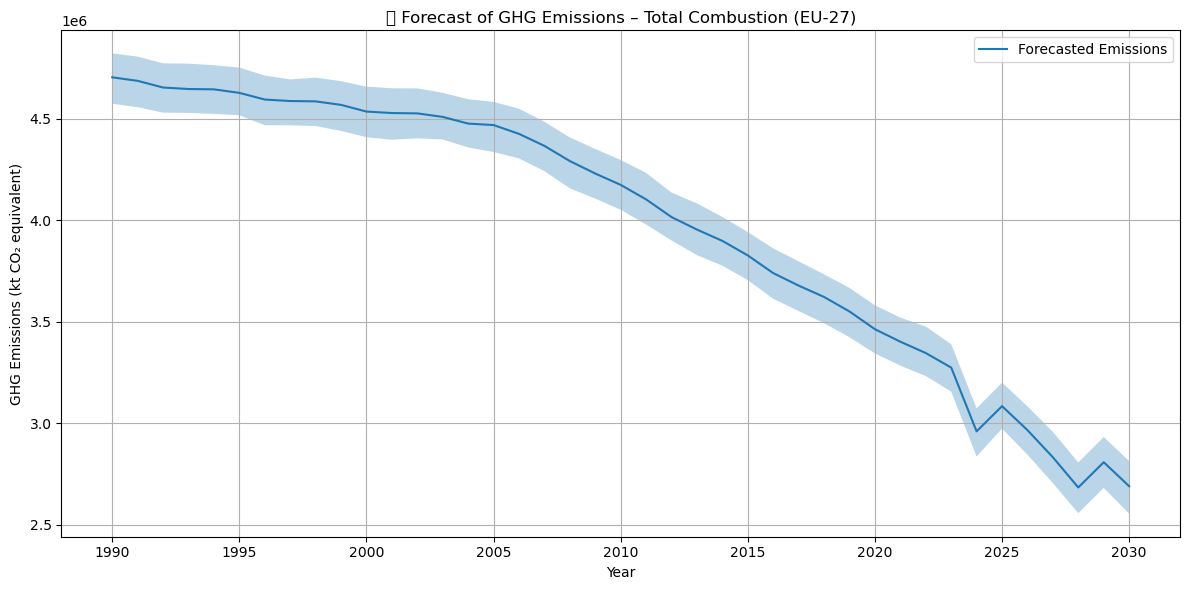

C:\Users\rites\AppData\Local\Temp\ipykernel_18044\2591263099.py:54: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


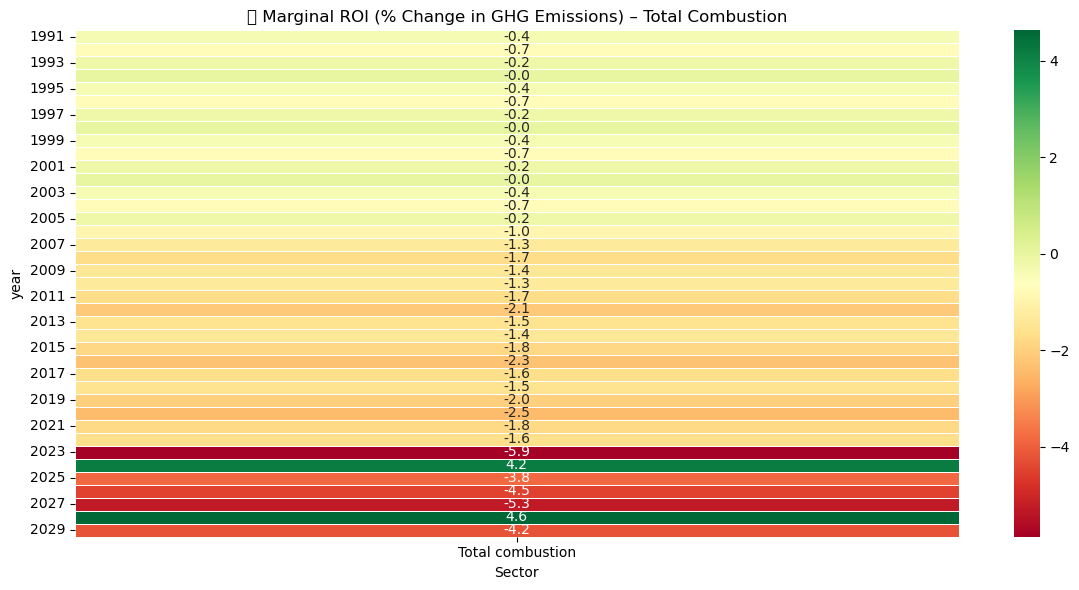

In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Manually input your dataset values ===
years = list(range(1990, 2024))  # 1990 to 2023
emissions = [
    4872570.64, 4767079.89, 4614787.09, 4534843.42, 4512512.71, 4563419.23, 4653972.24,
    4582121.43, 4542281.86, 4466530.17, 4454899.71, 4503703.15, 4489327.58, 4563937.17,
    4562529.86, 4545996.76, 4549497.28, 4499986.47, 4412787.48, 4095753.67, 4176633.40,
    4066905.91, 3996083.60, 3906687.48, 3764522.01, 3813427.74, 3810063.24, 3831154.77,
    3749884.77, 3587825.17, 3296846.78, 3464575.62, 3375504.36, 3105624.99
]

# === STEP 2: Create DataFrame and clean ===
df = pd.DataFrame({
    "ds": pd.to_datetime([f"{y}-01-01" for y in years]),
    "y": emissions
})

# === STEP 3: Prophet Forecast ===
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=7, freq='Y')
forecast = model.predict(future)

# Calculate YoY efficiency gain
forecast["year"] = forecast["ds"].dt.year
forecast["marginal_roi"] = forecast["yhat"].pct_change() * 100

# === STEP 4: Plot Forecast ===
plt.figure(figsize=(12, 6))
plt.plot(forecast["ds"], forecast["yhat"], label="Forecasted Emissions")
plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], alpha=0.3)
plt.title(" Forecast of GHG Emissions – Total Combustion (EU-27)")
plt.xlabel("Year")
plt.ylabel("GHG Emissions (kt CO₂ equivalent)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === STEP 5: Plot Marginal ROI Heatmap ===
roi_df = forecast[["year", "marginal_roi"]].dropna()
roi_df["Sector"] = "Total combustion"  # if doing multiple sectors later

pivot = roi_df.pivot_table(index="year", columns="Sector", values="marginal_roi", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".1f", linewidths=0.5)
plt.title(" Marginal ROI (% Change in GHG Emissions) – Total Combustion")
plt.tight_layout()
plt.show()



16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\rites\anaconda3\envs\pyspark_env\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
16:22:01 - cmdstanpy - IN

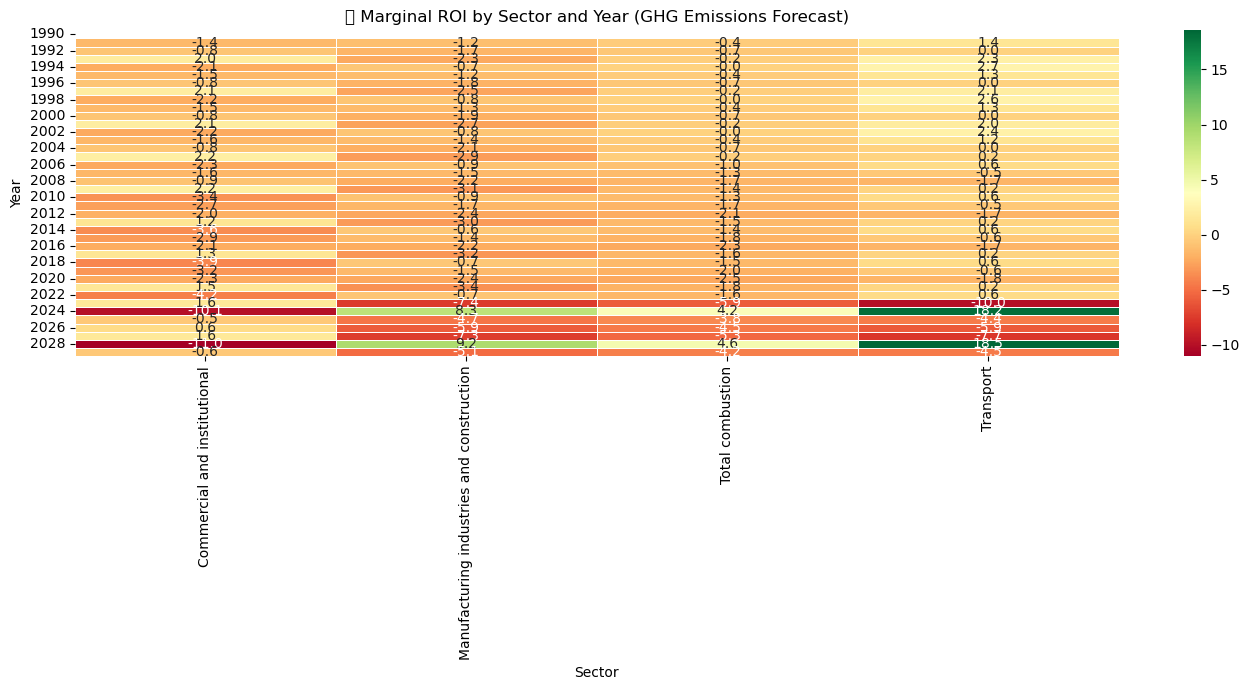

In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Manually Input the Dataset ===
sectors = {
    "Total combustion": [
        4872570.64, 4767079.89, 4614787.09, 4534843.42, 4512512.71, 4563419.23, 4653972.24, 4582121.43, 4542281.86, 4466530.17,
        4454899.71, 4503703.15, 4489327.58, 4563937.17, 4562529.86, 4545996.76, 4549497.28, 4499986.47, 4412787.48, 4095753.67,
        4176633.40, 4066905.91, 3996083.60, 3906687.48, 3764522.01, 3813427.74, 3810063.24, 3831154.77, 3749884.77, 3587825.17,
        3296846.78, 3464575.62, 3375504.36, 3105624.99
    ],
    "Manufacturing industries and construction": [
        721094, 677956.89, 639340.35, 619089.54, 617146.46, 638035.08, 629399.1, 620308.3, 595572.59, 580449.2,
        578582.53, 567184.23, 556932.16, 561974.53, 554467.75, 549472.28, 538122.05, 547842.54, 528827.69, 437381.44,
        469500.52, 460094.29, 443298.54, 425948.1, 410696.84, 419014.12, 423113.74, 430785.81, 429895.6, 417857.49,
        398060.99, 427500.88, 391687, 363429.83
    ],
    "Transport": [
        674049.78, 682697.44, 704536.1, 707941, 713249.22, 726078.88, 748077.74, 757750.41, 786722.38, 803193.06,
        799264.16, 813130.47, 821892.1, 829171.88, 842073.87, 844157.46, 860936.89, 864307.94, 850679.8, 824201.03,
        816120.07, 806801.7, 777027.72, 770967.47, 774240.43, 794313.19, 810982.73, 823549.94, 830888.06, 834174.44,
        721996.29, 780230.45, 804259.47, 794393.78
    ],
    "Commercial and institutional": [
        172193.56, 177288.2, 159590.47, 159450.09, 147507.67, 149113.78, 163025.04, 151276.51, 150817.75, 151121.5,
        144169.38, 157320.81, 151103.46, 146889.18, 150900.54, 158146.1, 164337.59, 140995.89, 153890.62, 153211.61,
        158937.86, 139573.3, 140455.41, 142306.9, 127241.85, 132434.3, 124764.11, 127531.93, 124312.31, 121612.91,
        115142.47, 118978.21, 107265.31, 101890.35
    ]
}

years = list(range(1990, 1990 + len(next(iter(sectors.values())))))

# === STEP 2: Combine All Sectors Into One DataFrame ===
df_all = pd.DataFrame()
for sector, values in sectors.items():
    df_sector = pd.DataFrame({
        "ds": pd.to_datetime([f"{y}-01-01" for y in years]),
        "y": values,
        "Sector": sector
    })
    df_all = pd.concat([df_all, df_sector], ignore_index=True)

# === STEP 3: Forecast Function ===
def forecast_sector(df, sector_name):
    df_sec = df[df["Sector"] == sector_name][["ds", "y"]].dropna()
    if df_sec.shape[0] < 2:
        return pd.DataFrame()
    model = Prophet()
    model.fit(df_sec)
    future = model.make_future_dataframe(periods=7, freq="Y")
    forecast = model.predict(future)
    forecast["Sector"] = sector_name
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "Sector"]]

# === STEP 4: Run Forecasts ===
forecasts = []
for sector in sectors.keys():
    fcast = forecast_sector(df_all, sector)
    if not fcast.empty:
        forecasts.append(fcast)

forecast_df = pd.concat(forecasts, ignore_index=True)
forecast_df["year"] = forecast_df["ds"].dt.year
forecast_df["marginal_roi"] = forecast_df.groupby("Sector")["yhat"].pct_change() * 100

# === STEP 5: Plot Heatmap ===
roi_dedup = (
    forecast_df.groupby(["year", "Sector"], as_index=False)
    .agg({"marginal_roi": "mean"})
)

pivot = roi_dedup.pivot(index="year", columns="Sector", values="marginal_roi")

plt.figure(figsize=(14, 7))
sns.heatmap(pivot, annot=True, cmap="RdYlGn", fmt=".1f", linewidths=0.5)
plt.title(" Marginal ROI by Sector and Year (GHG Emissions Forecast)")
plt.xlabel("Sector")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1]

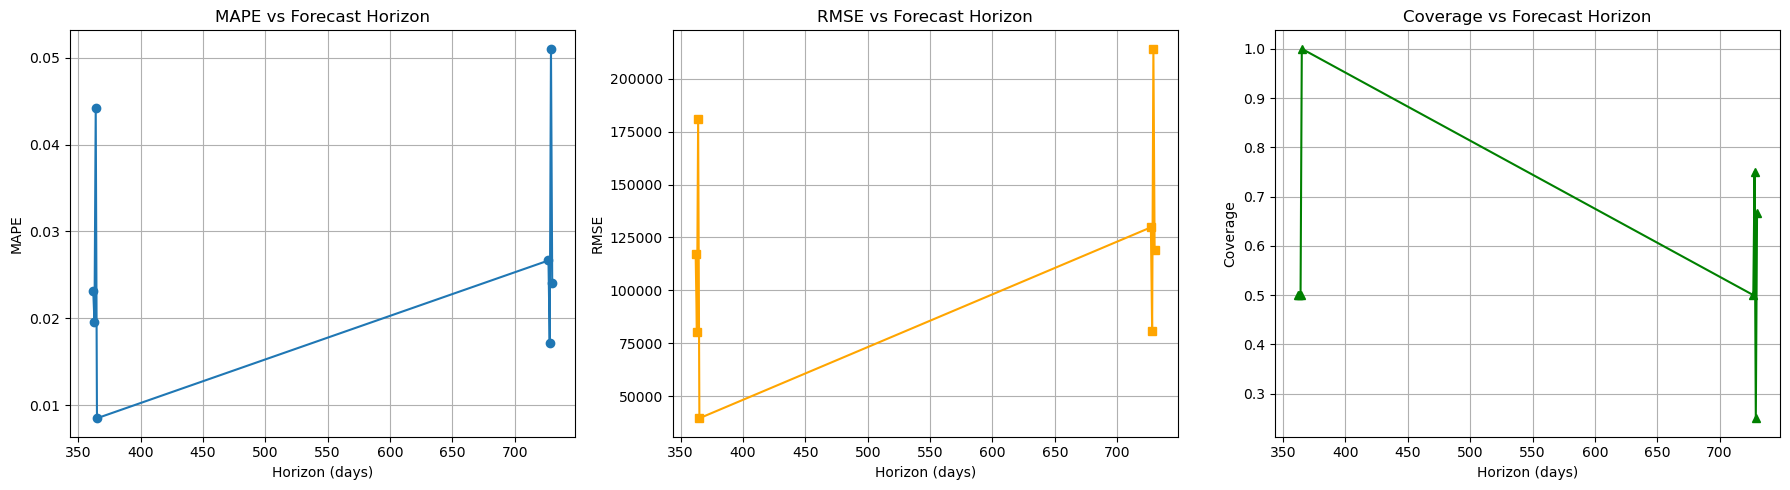

,horizon,mape,rmse,coverage
0,362 days,0.023200,117285.148910,0.5
1,363 days,0.019519,80367.618965,0.5
2,364 days,0.044200,181151.025625,0.5
3,365 days,0.008476,39624.459888,1.0
4,727 days,0.026659,129769.499427,0.5


In [16]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Reuse the cleaned df_all from previous step ===
# Filter one sector for rolling CV
sector_name = "Total combustion"
df_sector = df_all[df_all["Sector"] == sector_name][["ds", "y"]].dropna()

# === Fit model ===
model = Prophet()
model.fit(df_sector)

# === Cross-validation setup ===
df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon='730 days')
df_perf = performance_metrics(df_cv)

# === Plotting MAPE, RMSE, and Coverage ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAPE Plot
axs[0].plot(df_perf['horizon'].dt.days, df_perf['mape'], marker='o')
axs[0].set_title("MAPE vs Forecast Horizon")
axs[0].set_xlabel("Horizon (days)")
axs[0].set_ylabel("MAPE")
axs[0].grid(True)

# RMSE Plot
axs[1].plot(df_perf['horizon'].dt.days, df_perf['rmse'], marker='s', color='orange')
axs[1].set_title("RMSE vs Forecast Horizon")
axs[1].set_xlabel("Horizon (days)")
axs[1].set_ylabel("RMSE")
axs[1].grid(True)

# Coverage Plot
axs[2].plot(df_perf['horizon'].dt.days, df_perf['coverage'], marker='^', color='green')
axs[2].set_title("Coverage vs Forecast Horizon")
axs[2].set_xlabel("Horizon (days)")
axs[2].set_ylabel("Coverage")
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Return performance metrics
df_perf[['horizon', 'mape', 'rmse', 'coverage']].head()
